In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from tqdm.notebook import tqdm
rng = np.random.default_rng()

In [2]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [3]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

In [4]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [5]:
num_classes = 10
output_cap_size = 200
cap_size = [200, output_cap_size]
num_assembly = [10, num_classes]
num_learn_areas = len(cap_size) - 1
n_in = 784
n_neurons = [num_assembly[l] * c for l, c in enumerate(cap_size)]
sparsity = 0.1
n_rounds = 150
beta = 1e0

# Random mask on inter-area connections
# Choose 10% of connections and not the diagnal
mask = [(rng.random((n_neurons[l], n_neurons[l])) < sparsity) & np.logical_not(np.eye(n_neurons[l], dtype=bool)) for l in range(num_learn_areas+1)]
W = [np.ones((n_neurons[l], n_neurons[l])) * mask[l] for l in range(num_learn_areas+1)]

# Random mask on input-learning area connections
mask_a = [(rng.random((n_in, n_neurons[l])) < sparsity) for l in range(num_learn_areas)]
A = [np.ones((n_in, n_neurons[l])) * mask_a[l] for l in range(num_learn_areas)]

# Random mask on input-learning area connections
mask_b = [(rng.random((n_neurons[l], n_neurons[-1])) < sparsity) for l in range(num_learn_areas)]
B = [np.ones((n_neurons[l], n_neurons[-1])) * mask_b[l] for l in range(num_learn_areas)]


In [6]:
from scipy.signal import convolve
# k-cap on convolved input pixels
n_examples = 5000
sensory_cap_size = 200
examples = np.zeros((num_classes, n_examples, 784))
for i in range(num_classes):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), sensory_cap_size)

In [7]:
# Init connections from each neuron to sum up to 1
for l in range(num_learn_areas):
    W[l] = np.ones_like(W[l]) * mask[l]
    W[l] /= W[l].sum(axis=0, keepdims=True) 
    A[l] = np.ones_like(A[l]) * mask_a[l]
    A[l] /= A[l].sum(axis=0, keepdims=True)
    B[l] = np.ones_like(B[l]) * mask_b[l]
    B[l] /= B[l].sum(axis=0, keepdims=True)
    
bias = [np.zeros(n_neurons[l]) for l in range(num_learn_areas+1)]
b = -1
activations = [np.zeros((num_classes, n_rounds, n_neurons[l])) for l in range(num_learn_areas+1)]

# Iterate over each class
for i in range(num_classes):
    
    # Iterate over several examples
    for t in range(1, n_rounds):
        
        input = examples[i, t-1]
        
        for l in range(num_learn_areas):
            activations[l][i, t] = k_cap(
                input@A[l] + activations[l][i, t-1]@W[l] + bias[l], cap_size[l]
            ) 
    
        output_activation = activations[-1][i, t-1]@W[-1]
        for l in range(num_learn_areas):
            output_activation += activations[l][i, t-1]@B[l]
        output_activation += bias[-1]
        activations[-1][i, t] = k_cap(output_activation, cap_size[-1])
        
        # update weights
        for l in range(num_learn_areas):
            A[l][(input > 0)[:, np.newaxis] & (activations[l][i, t] > 0)[np.newaxis, :]] *= 1 + beta
            B[l][(activations[l][i, t-1] > 0)[:, np.newaxis] & (activations[-1][i, t] > 0)[np.newaxis, :]] *= 1 + beta
            W[l][(activations[l][i, t-1] > 0)[:, np.newaxis] & (activations[l][i, t] > 0)[np.newaxis, :]] *= 1 + beta
        
        W[-1][(activations[-1][i, t-1] > 0)[:, np.newaxis] & (activations[-1][i, t] > 0)[np.newaxis, :]] *= 1 + beta
        
    for l in range(num_learn_areas):
        A[l] /= A[l].sum(axis=0, keepdims=True)
        W[l] /= W[l].sum(axis=0, keepdims=True)
        bias[l][activations[l][i, t] > 0] += b
    
    W[-1] /= W[-1].sum(axis=0, keepdims=True)
    bias[-1][activations[-1][i, t] > 0] += b

In [8]:
n_rounds = 6
la_outputs = [np.zeros((num_classes, n_rounds+1, n_examples, n_neurons[l])) for l in range(num_learn_areas)]
outputs = np.zeros((num_classes, n_rounds+1, n_examples, n_neurons[-1]))
for i in tqdm(np.arange(num_classes)):
    for j in range(n_rounds): 
        outputs[i, j+1] = outputs[i, j] @ W[-1]
        for l in range(num_learn_areas):
            la_outputs[l][i, j+1] = k_cap(la_outputs[l][i, j] @ W[l] + examples[i] @ A[l] + bias[l], cap_size[l])
    
            outputs[i, j+1] += la_outputs[l][i, j] @ B[l]
        outputs[i, j+1] = k_cap(outputs[i, j+1]+bias[-1], cap_size[-1]) 


  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
outputs.shape

(10, 7, 5000, 2000)

In [10]:
# c is a mask for identifying each assembly
# set top k neurons to value 1 and 0 otherwise 
c = np.zeros((num_classes, n_neurons[-1])) 

for i in range(num_classes):
    c[i, activations[-1][i, -1].argsort()[-cap_size[-1]:]] = 1

predictions = (outputs[:, -1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(num_classes)[:, np.newaxis]).sum(axis=-1) / n_examples

In [11]:
acc, acc.mean()

(array([0.8158, 0.9682, 0.5996, 0.6708, 0.7636, 0.6512, 0.607 , 0.816 ,
        0.407 , 0.5508]),
 0.6849999999999999)

In [23]:
idx = np.full(n_neurons[-1], -1, dtype=int)
act = activations[-1][:, -1].copy()       # final state activation after training each class
act.shape

(10, 2000)

In [24]:
for i, j in enumerate(range(num_classes)):
    idx[i*cap_size[-1]:(i+1)*cap_size[-1]] = act[j].argsort()[-cap_size[-1]:][::-1]
    act[:, idx[i*cap_size[-1]:(i+1)*cap_size[-1]]] = -1
    
r = np.arange(n_neurons[-1])
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size[-1]:] = np.unique(r)[1:]

<IPython.core.display.Javascript object>


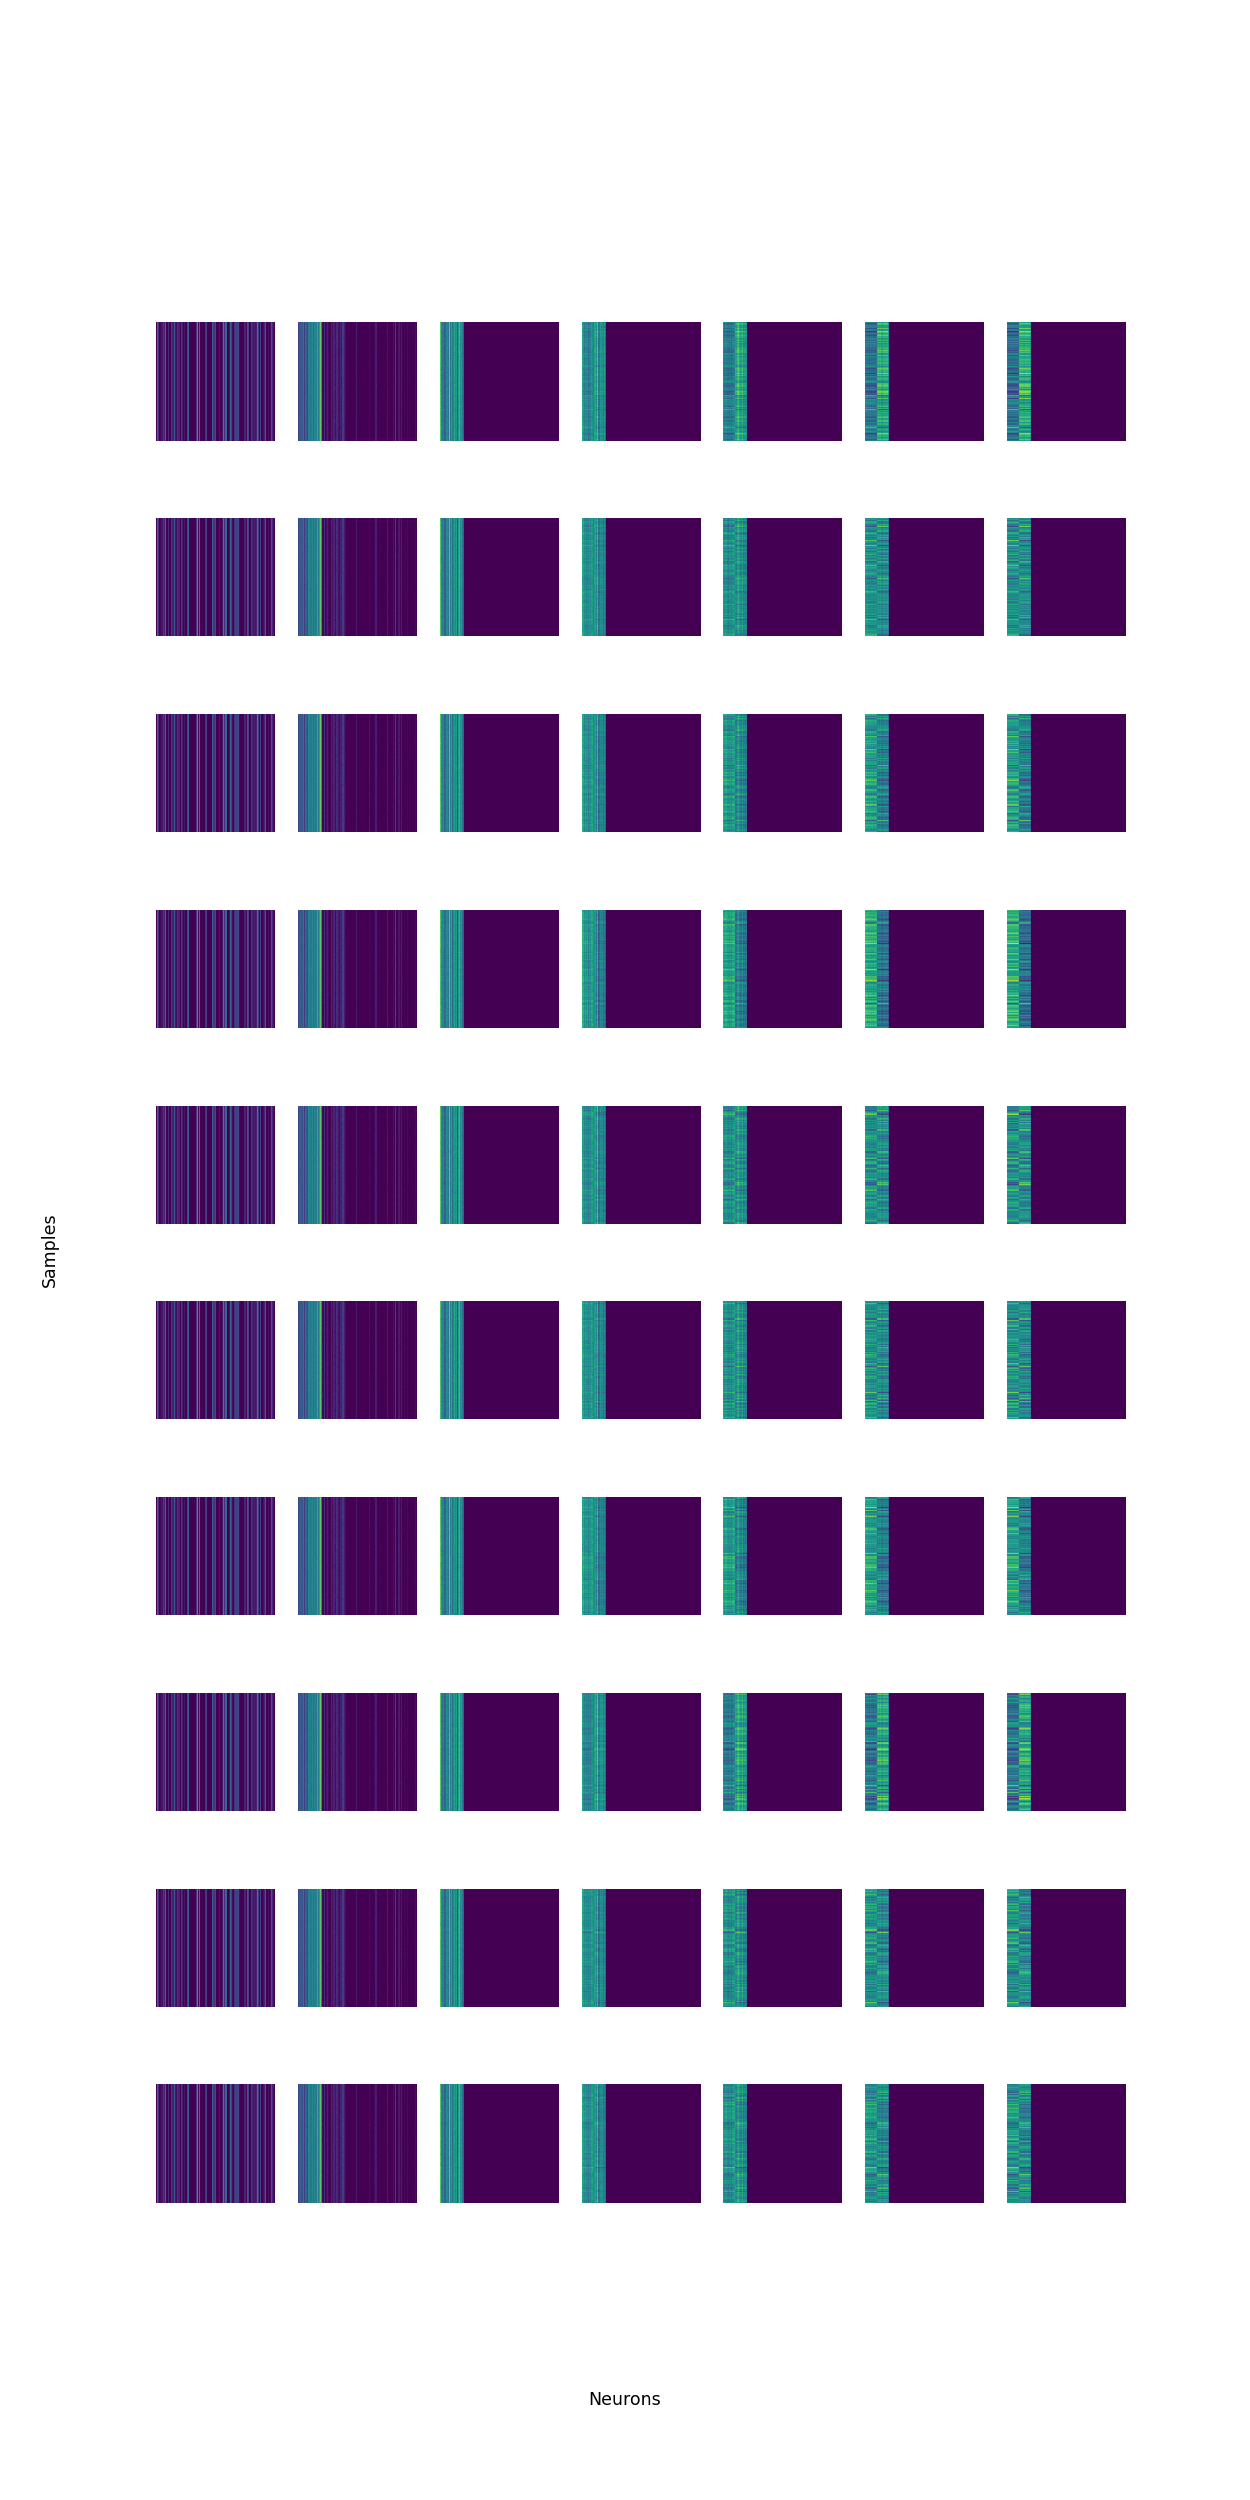

Text(0.04, 0.5, 'Samples')

In [25]:
fig, axes = plt.subplots(num_classes, n_rounds, figsize=(10, 2 * num_classes), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:n_neurons[-1], idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>


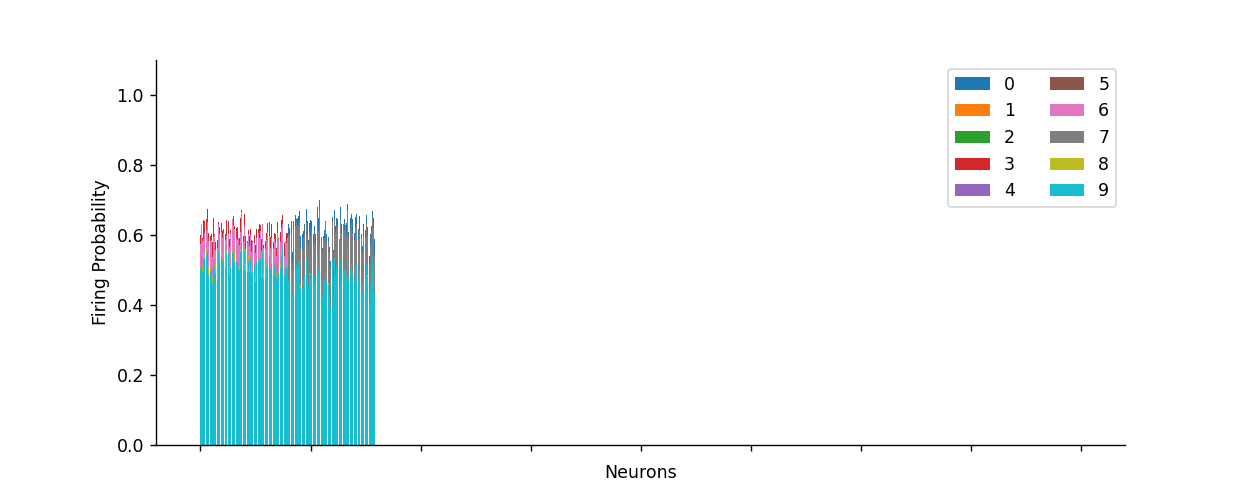

Text(0, 0.5, 'Firing Probability')

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(num_classes):
    # Pass each sample to the model and get its result 
    ax.bar(np.arange(n_neurons[-1]), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons')
ax.set_ylabel('Firing Probability')

In [19]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)

In [20]:
v = 0.1 * rng.standard_normal((10, n_neurons))
targets = np.zeros((100, 10))

for i in range(10):
    targets[i*10:(i+1)*10, i] = 1
update = np.zeros_like(v)

TypeError: 'list' object cannot be interpreted as an integer

In [16]:
for _ in range(100):
    permutation = rng.permutation(n_examples - 1000)
    for j in range((n_examples - 1000) // 10):
        batch = outputs[:, 1, permutation[j*10:(j+1)*10]].reshape(10 * 10, n_neurons)
        scores = softmax((batch[:, :, np.newaxis] * v.T[np.newaxis, :, :]).sum(axis=1))
        update = 0.5 * update + 1e-3 * (batch[:, np.newaxis, :] * (scores - targets)[:, :, np.newaxis]).sum(axis=0)
        v -= update

KeyboardInterrupt: 

In [ ]:
((outputs[:, 1, :-1000] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 40000

In [ ]:
((outputs[:, 1, -1000:] @ v.T).argmax(axis=-1) == np.arange(10)[:, np.newaxis]).sum() / 10000